In [1]:
%%capture
!pip install plotly
!pip install nltk
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Visualisierungen
- Mean Sentiment over time per party                ✅
- HOF per MP                                        ✅
-  Männliche vs. weibliche Politiker vergleich      ✅
- Minority vergleich (überhaupt möglich?)
- Hate unter Politikern
- Wordclouds

# Data Analysis

## Plot Gender

In [28]:
df = pd.read_csv("politician_mentions_predicted_exploded.csv")
df.head(2)

/tmp/ipykernel_631/3689035596.py:1: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



,Unnamed: 0.2,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,quote_count,...,mentioned,Unnamed: 0.1,Unnamed: 0,full_name,party,twitter,username_,user,Geschlecht,Gewählt in Vorperiode
0,0,7.133614e+17,stbrandner,38579.0,31499,"Industriekaufmann, Rechtsanwalt, MdB🇩🇪 - direk...","Mal hier, mal da...",@Karl_Lauterbach Wer jemanden anzeigt...😉\nhtt...,2022-12-04 18:54:10+00:00,1.0,...,karl_lauterbach,361,361,Prof. Dr. Karl Lauterbach,SPD,['https://www.twitter.com/karl_lauterbach'],karl_lauterbach,karl_lauterbach,Herrn,ja
1,1,8.109576e+17,petrbystronafd,21643.0,10673,🇩🇪 Aussenpolitischer Sprecher der @AfDimBundes...,"München, Bayern",@Karl_Lauterbach Tweet aus einem Parallelunive...,2022-11-26 22:41:30+00:00,0.0,...,karl_lauterbach,361,361,Prof. Dr. Karl Lauterbach,SPD,['https://www.twitter.com/karl_lauterbach'],karl_lauterbach,karl_lauterbach,Herrn,ja


In [29]:
frau = df[df.Geschlecht == "Frau"]
print(len(frau))
mann = df[df.Geschlecht == "Herrn"]
print(len(mann))
print(df.Geschlecht.value_counts())

21281
48613
Herrn    48613
Frau     21281
Name: Geschlecht, dtype: int64


In [30]:
frau_hof = frau[frau["model_predictions"] == 1]
mann_hof = mann[mann["model_predictions"] == 1]
print(len(frau_hof))
print(len(mann_hof))
# 19.6% HOF bei Frauen
# 20.8% HOF bei Männern -> hauptsächlich wegen Karl Lauterbach

# 5 höchsten Ämter:
# 1. Bundespräsident: Steinmeier
# 2. Präsident des Bundestags: Bärbel Bas
# 3. Bundeskanzler: Olaf Scholz
# 4. Bundesratspräsident: Peter Tschentscher
# 5. Präsident des Bundesverfassungsgericht: Stephan Harbarth

461
1331


In [6]:
print(len(frau.full_name.unique()))

246


In [7]:
print(len(mann.full_name.unique()))

469


In [8]:
len(df)

69894

In [31]:
df["HOF"] = df["model_predictions"]
df.loc[(df.model_predictions == 1),'Label']='HOF'
df.loc[(df.model_predictions == 0),'Label']='NOT'

In [10]:
df.Geschlecht.value_counts()

Herrn    48613
Frau     21281
Name: Geschlecht, dtype: int64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



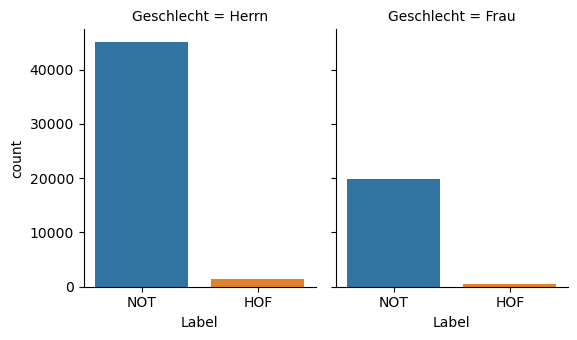

In [12]:
# Plot
g = sns.catplot("Label", col="Geschlecht", col_wrap=3,
                data=df,
                kind="count", height=3.5, aspect=.8, 
                palette='tab10')

#fig.suptitle('sf')
plt.show()
g.savefig('./plots/politician_gender_hof_distribution.png')

In [13]:
from time_plots import plot_gender_percentage

                    0.0  1.0
model_predictions  97.3  2.7
Frau               97.7  2.3
Herrn              97.1  2.9


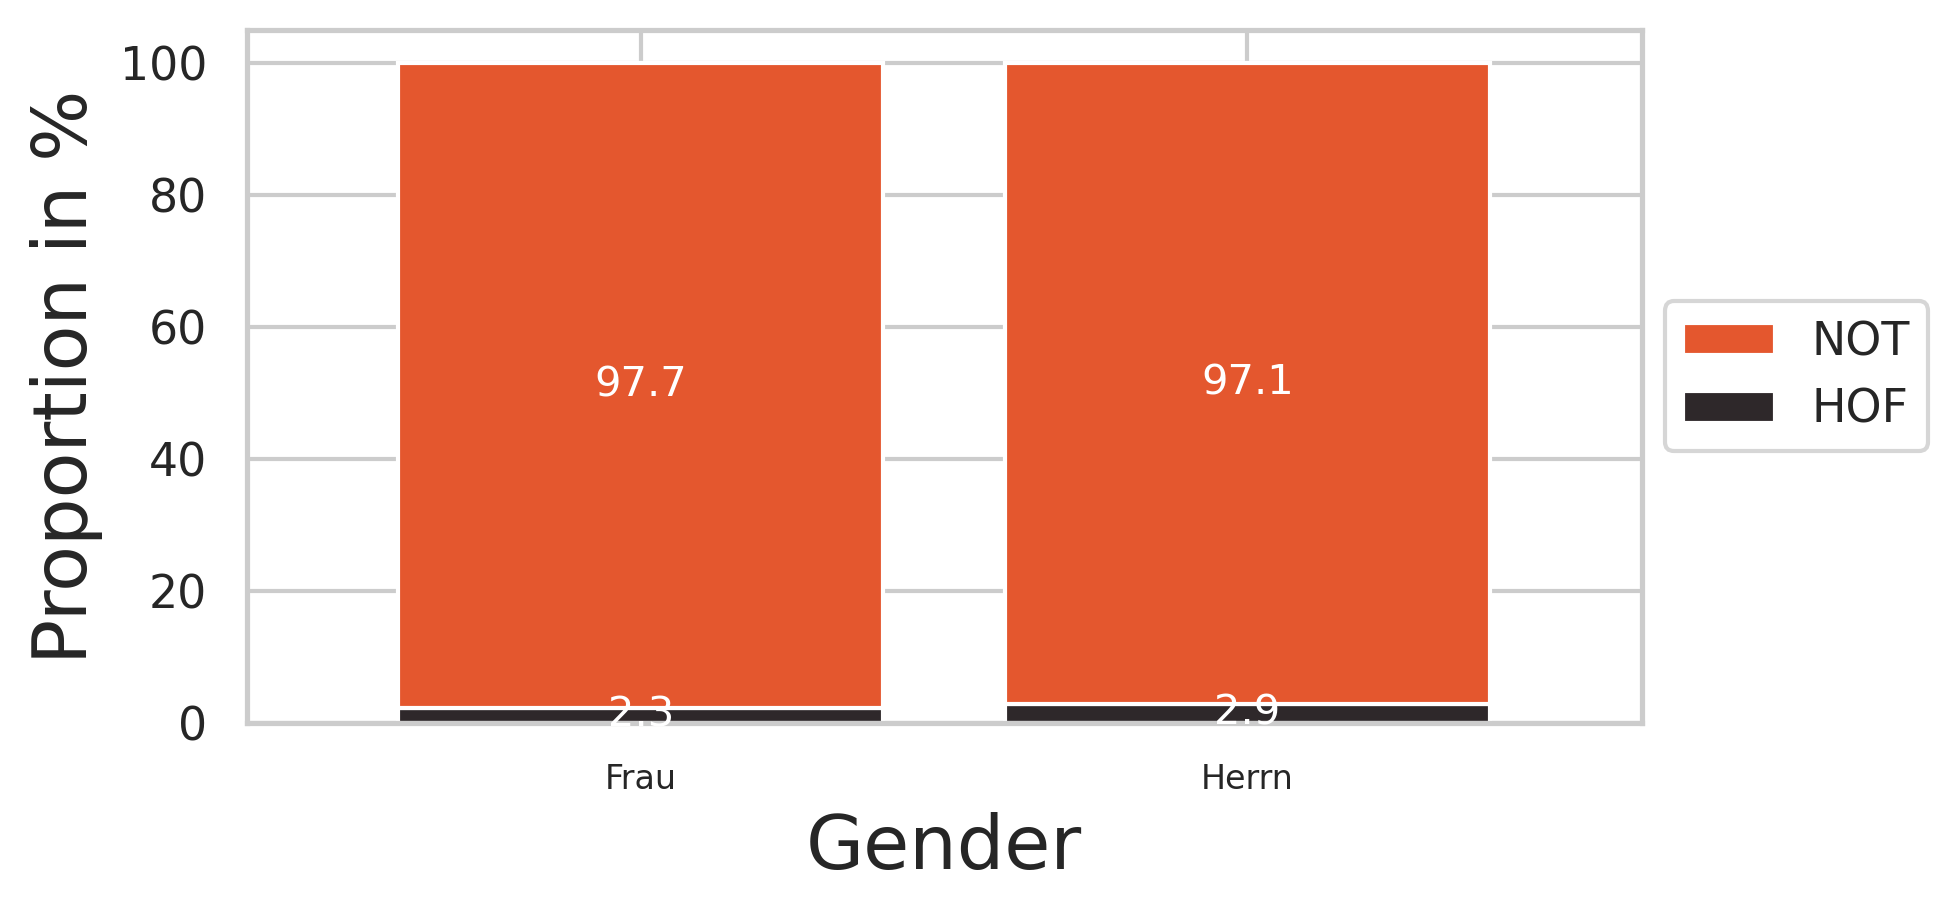

In [14]:
plot_gender_percentage(df,"./plots/politician_gender_hof_distribution")

## Hate per MP

In [15]:
hof = df[df["Label"] == "HOF"]
no = df[df["Label"] == "NOT"]

In [17]:
hof_val_counts = pd.DataFrame(hof.full_name.value_counts())
hof_val_counts[:20]

,full_name
Olaf Scholz,187
Prof. Dr. Karl Lauterbach,117
Christian Lindner,87
Dr. Ralf Stegner,73
Friedrich Merz,57
Saskia Esken,56
Dr. Marie-Agnes Strack-Zimmermann,35
Lars Klingbeil,34
Dr. Marco Buschmann,33
Stephan Brandner,33


In [18]:
not_val_counts = pd.DataFrame(no.full_name.value_counts())
not_val_counts[:20]

,full_name
Olaf Scholz,4551
Christian Lindner,4289
Friedrich Merz,1584
Jens Spahn,1506
Prof. Dr. Karl Lauterbach,1460
Saskia Esken,1458
Konstantin Kuhle,1103
Kevin Kühnert,954
Dr. Marco Buschmann,948
Lars Klingbeil,942


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


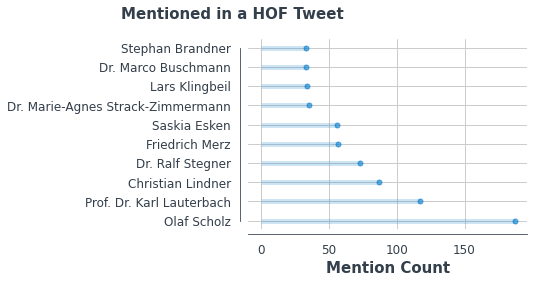

In [19]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

hof_val_counts = hof_val_counts[:10]
# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(hof_val_counts.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=hof_val_counts['full_name'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(hof_val_counts['full_name'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Mention Count', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, hof_val_counts.index)

# add an horizonal label for the y axis 
fig.text(-0.23, 0.96, 'Mentioned in a HOF Tweet', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
#ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('plots/politician_hof_on_mps.png', dpi=300, bbox_inches='tight')

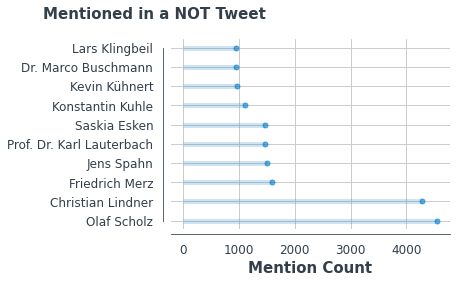

In [20]:
# set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

hof_val_counts = not_val_counts[:10]
# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(hof_val_counts.index)+1))

fig, ax = plt.subplots(figsize=(5,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=hof_val_counts['full_name'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(hof_val_counts['full_name'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Mention Count', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, hof_val_counts.index)

# add an horizonal label for the y axis 
fig.text(-0.23, 0.96, 'Mentioned in a NOT Tweet', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
#ax.set_xlim(0,25)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('plots/politician_not_on_mps.png', dpi=300, bbox_inches='tight')

# Plot Mention-Network

In [22]:
df.head()

,Unnamed: 0.2,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,quote_count,...,Unnamed: 0,full_name,party,twitter,username_,user,Geschlecht,Gewählt in Vorperiode,HOF,Label
0,0,7.133614e+17,stbrandner,38579.0,31499,"Industriekaufmann, Rechtsanwalt, MdB🇩🇪 - direk...","Mal hier, mal da...",@Karl_Lauterbach Wer jemanden anzeigt...😉\nhtt...,2022-12-04 18:54:10+00:00,1.0,...,361,Prof. Dr. Karl Lauterbach,SPD,['https://www.twitter.com/karl_lauterbach'],karl_lauterbach,karl_lauterbach,Herrn,ja,0.0,NOT
1,1,8.109576e+17,petrbystronafd,21643.0,10673,🇩🇪 Aussenpolitischer Sprecher der @AfDimBundes...,"München, Bayern",@Karl_Lauterbach Tweet aus einem Parallelunive...,2022-11-26 22:41:30+00:00,0.0,...,361,Prof. Dr. Karl Lauterbach,SPD,['https://www.twitter.com/karl_lauterbach'],karl_lauterbach,karl_lauterbach,Herrn,ja,0.0,NOT
2,2,8.109576e+17,petrbystronafd,21643.0,10673,🇩🇪 Aussenpolitischer Sprecher der @AfDimBundes...,"München, Bayern","Das kommt dabei heraus, wenn @MarcoBuschmann ...",2022-08-16 15:02:20+00:00,1.0,...,361,Prof. Dr. Karl Lauterbach,SPD,['https://www.twitter.com/karl_lauterbach'],karl_lauterbach,karl_lauterbach,Herrn,ja,1.0,HOF
3,3,7.971373e+17,tino_chrupalla,36304.0,1201,Bundessprecher der #AfD | Fraktionsvorsitzend...,Sachsen,Vierfach geimpft sitzt @Karl_Lauterbach corona...,2022-08-10 11:46:02+00:00,9.0,...,361,Prof. Dr. Karl Lauterbach,SPD,['https://www.twitter.com/karl_lauterbach'],karl_lauterbach,karl_lauterbach,Herrn,ja,0.0,NOT
4,4,9.558998e+17,drchristinabaum,2584.0,923,von 2016-2021 für die AfD im Landtag BW. Wahlk...,"Baden-Württemberg, Deutschland",Schwere #Nebenwirkungen deutlich häufiger als ...,2022-07-23 17:54:15+00:00,0.0,...,361,Prof. Dr. Karl Lauterbach,SPD,['https://www.twitter.com/karl_lauterbach'],karl_lauterbach,karl_lauterbach,Herrn,ja,0.0,NOT


In [32]:
df = df[["username", "user", "party", "Label"]]

In [33]:
# Merge username with twitter usernames to get party
twitter = pd.read_csv("twitter_usernames_extracted.csv",sep=";")
twitter['username'] = twitter['username'].map(lambda x: x.lower() if isinstance(x,str) else x)

df = df.merge(twitter, left_on='username', right_on='username',suffixes=['', '_'])
df = df[["username", "party_", "user", "party", "Label"]]

In [34]:
print(df.columns.tolist())

['username', 'party_', 'user', 'party', 'Label']


In [37]:
df = df.rename(columns={"party_": "party" ,"user": "mentioned_user", "party": "mentioned_party"})
df

,username,party,mentioned_user,mentioned_party,Label
0,stbrandner,AfD,karl_lauterbach,SPD,NOT
1,stbrandner,AfD,karl_lauterbach,SPD,NOT
2,stbrandner,AfD,rene_springer,AfD,NOT
3,stbrandner,AfD,rene_springer,AfD,NOT
4,stbrandner,AfD,mastrackzi,FDP,NOT
...,...,...,...,...,...
66085,frankeedgar,SPD,timon_gremmels,SPD,NOT
66086,schneider_cux,SPD,stefwenzel,Bündnis 90/Die Grünen,NOT
66087,moritzoppelt,CDU/CSU,larscastellucci,SPD,NOT
66088,moritzoppelt,CDU/CSU,larscastellucci,SPD,NOT


In [38]:
df.to_csv("df_for_network_plot.csv")

In [ ]:
import pan